**"Bayesian adaptive prior, is that you?": Comparing different approaches of mixed effects modeling**

Survival analysis

- What is survival analysis?
- Re-creating McElreath's
- Austin Rochford's
- 
- How can we used mixed effects modeling?

- Pymc survival analysis [here](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/survival_analysis/bayes_param_survival_pymc3.html)

- Following Solomon Kurz's version [here](https://bookdown.org/content/4857/god-spiked-the-integers.html#bonus-survival-analysis).



In [71]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns
from scipy.stats import expon
import xarray as xr

In [7]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)
az.rcParams["stats.hdi_prob"] = 0.95 

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

# Load Austin cat data

Data from [here](https://github.com/KjFox/AustinCats/blob/master/data-raw/cats.csv).

In [10]:
d = pd.read_csv('../other_data/AustinCats.csv')
d.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


In [15]:
# Look at the distribution of cat colors
d['color'].value_counts().sort_index().head(10)

color
Agouti                        3
Agouti/Brown Tabby            1
Agouti/White                  1
Apricot                       1
Black                      2965
Black Smoke                  83
Black Smoke/Black Tiger       1
Black Smoke/White            21
Black Tabby                 119
Black Tabby/White            43
Name: count, dtype: int64

In [16]:
# assign the value black to black cats
d['black'] = np.where(d['color']=='Black', 'black', 'other')
#   d %>% 
#   mutate(black = ifelse(color == "Black", "black", "other"))


In [28]:
# proportion of each group
d['black'].value_counts() / d['black'].count()

black
other    0.867373
black    0.132627
Name: count, dtype: float64

In [29]:
d['out_event'].value_counts().sort_index()

out_event
Adoption      11351
Censored        549
Died            369
Disposal          9
Euthanasia      636
Missing          28
Transfer       9414
Name: count, dtype: int64

In [32]:
d['adopted'] = np.where(d['out_event']=='Adoption', 1, 0)
d['censored'] = np.where(d['out_event']!='Adoption', 1, 0)



<Axes: xlabel='days_to_event', ylabel='Count'>

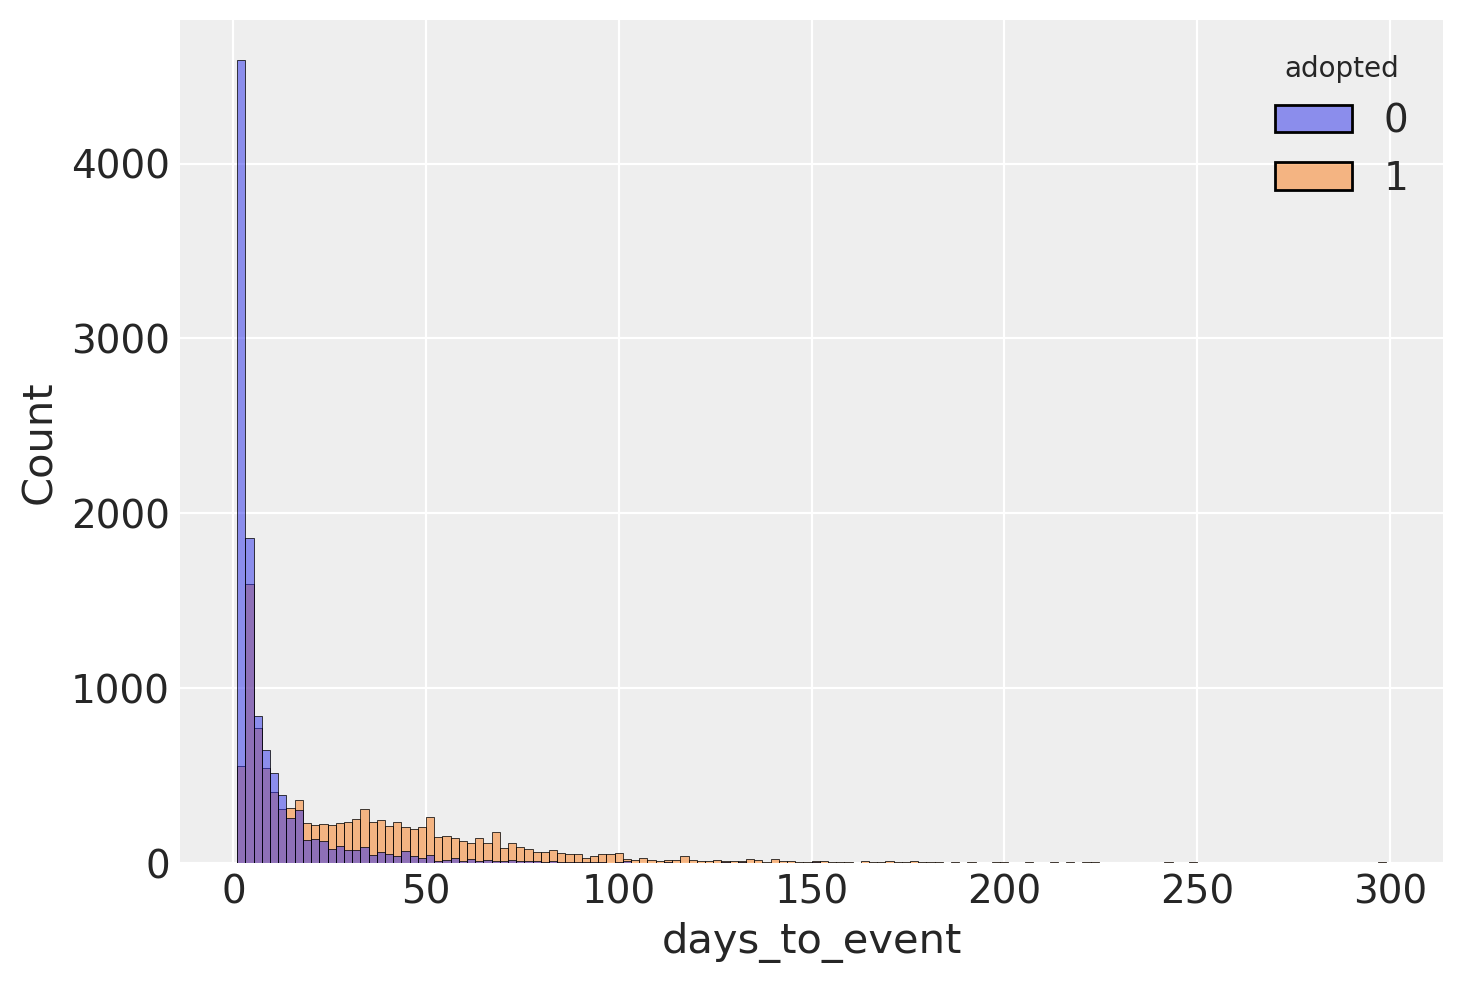

In [46]:
sns.histplot(
    data=d.query("days_to_event < 300"),
    x='days_to_event',
    hue='adopted'
)

# Fit model with exponential likelihood

To produce the probability density function for the exponential distribution:

$f(y) = \lambda e^{-\lambda y}$

where $y$ is non-negative and continuous (the `days_to_event` in our case).


The mean of the exponential distribution is the inverse of the rate:

(see how to align equations)

Check how pymc parameterizes models. If it's via $E[y]$ then you might need a log link.

$ E[y] = \frac{1}{\lambda} $

$ \text{days\_to\_event}_i | \text{censored}_i = 0 \sim \operatorname{Exponential}(\lambda_i) $

$ \text{days\_to\_event}_i | \text{censored}_i = 1 \sim \operatorname{Exponential-CCDF}(\lambda_i) $

$ \lambda_i = 1 / \mu_i $

$ \log \mu_i = \alpha_{\text{black}[i]} $

$ \alpha \sim \operatorname{Normal}(0,1)$



In [49]:
d.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,black,adopted,censored
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,other,0,1
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,other,0,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,other,1,0
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,other,0,1
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,other,0,1


In [52]:
d['black'].value_counts()

black
other    19391
black     2965
Name: count, dtype: int64

In [55]:
d['black_cat'] = pd.Categorical(d['black'], categories=['other', 'black']).codes
d.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,black,adopted,censored,black_cat
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,other,0,1,0
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,other,0,1,0
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,other,1,0,0
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,other,0,1,0
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,other,0,1,0


In [56]:
# from Rojan

def likelihood(lam,obs_value,censored):
    return (censored*pt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
    cid=pm.Data('cid', d['black_cat'])
    adopted=pm.intX(pm.Data('adopted',d['adopted']))
    a=pm.Normal('a',0,1,shape=2)
    mu = pm.math.exp(a[cid])
    lam= pm.Deterministic('lam',1/mu)
    
    D=pm.Potential('D',likelihood(lam=lam,obs_value=d['days_to_event'].values,censored=adopted))
    
    trace_1=pm.sample()


/Users/benlacar/opt/anaconda3/envs/pymc_env_2307/lib/python3.11/site-packages/pymc/data.py:428: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [59]:
# not specifying var_names will return lambda for each color
df_summary_a = az.summary(trace_1, var_names='a')
df_summary_a.head()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.880,0.010,3.861,3.900,0.0,0.0,4302.0,2733.0,1.0
a[1],4.051,0.026,4.003,4.104,0.0,0.0,3999.0,2861.0,1.0


We modeled $\alpha$ and we want to get the rate $\lambda$. (Following from Kurz.)

\begin{align*}
\log \mu             & = \alpha_\text{black}, && \text{and} \\
\lambda              & = 1 / \mu,             && \text{therefore} \\
\lambda_\text{black} & = 1 / \exp(\alpha_\text{black}).
\end{align*}



In [64]:
# rates for each color
1 / np.exp(df_summary_a.loc[:, ['mean', 'hdi_2.5%', 'hdi_97.5%']])

,mean,hdi_2.5%,hdi_97.5%
a[0],0.020651,0.021047,0.020242
a[1],0.017405,0.018261,0.016507


This shows that the mean lambda (rate of adoption) for black cats is slower than cats of other color.

Let's visualize by looking at the impact of this over 100 days where the y-axis is the probability of adoption.

In [103]:
rate_other = 1 / np.exp(df_summary_a.loc['a[0]', ['mean', 'hdi_2.5%', 'hdi_97.5%']])
rate_other

mean         0.020651
hdi_2.5%     0.021047
hdi_97.5%    0.020242
Name: a[0], dtype: float64

In [70]:
time = np.linspace(0, 100, 100)
time

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

In [82]:
-df_summary_a.loc['a[0]', ['mean']]

mean   -3.88
Name: a[0], dtype: float64

In [109]:
rate_other.index

Index(['mean', 'hdi_2.5%', 'hdi_97.5%'], dtype='object')

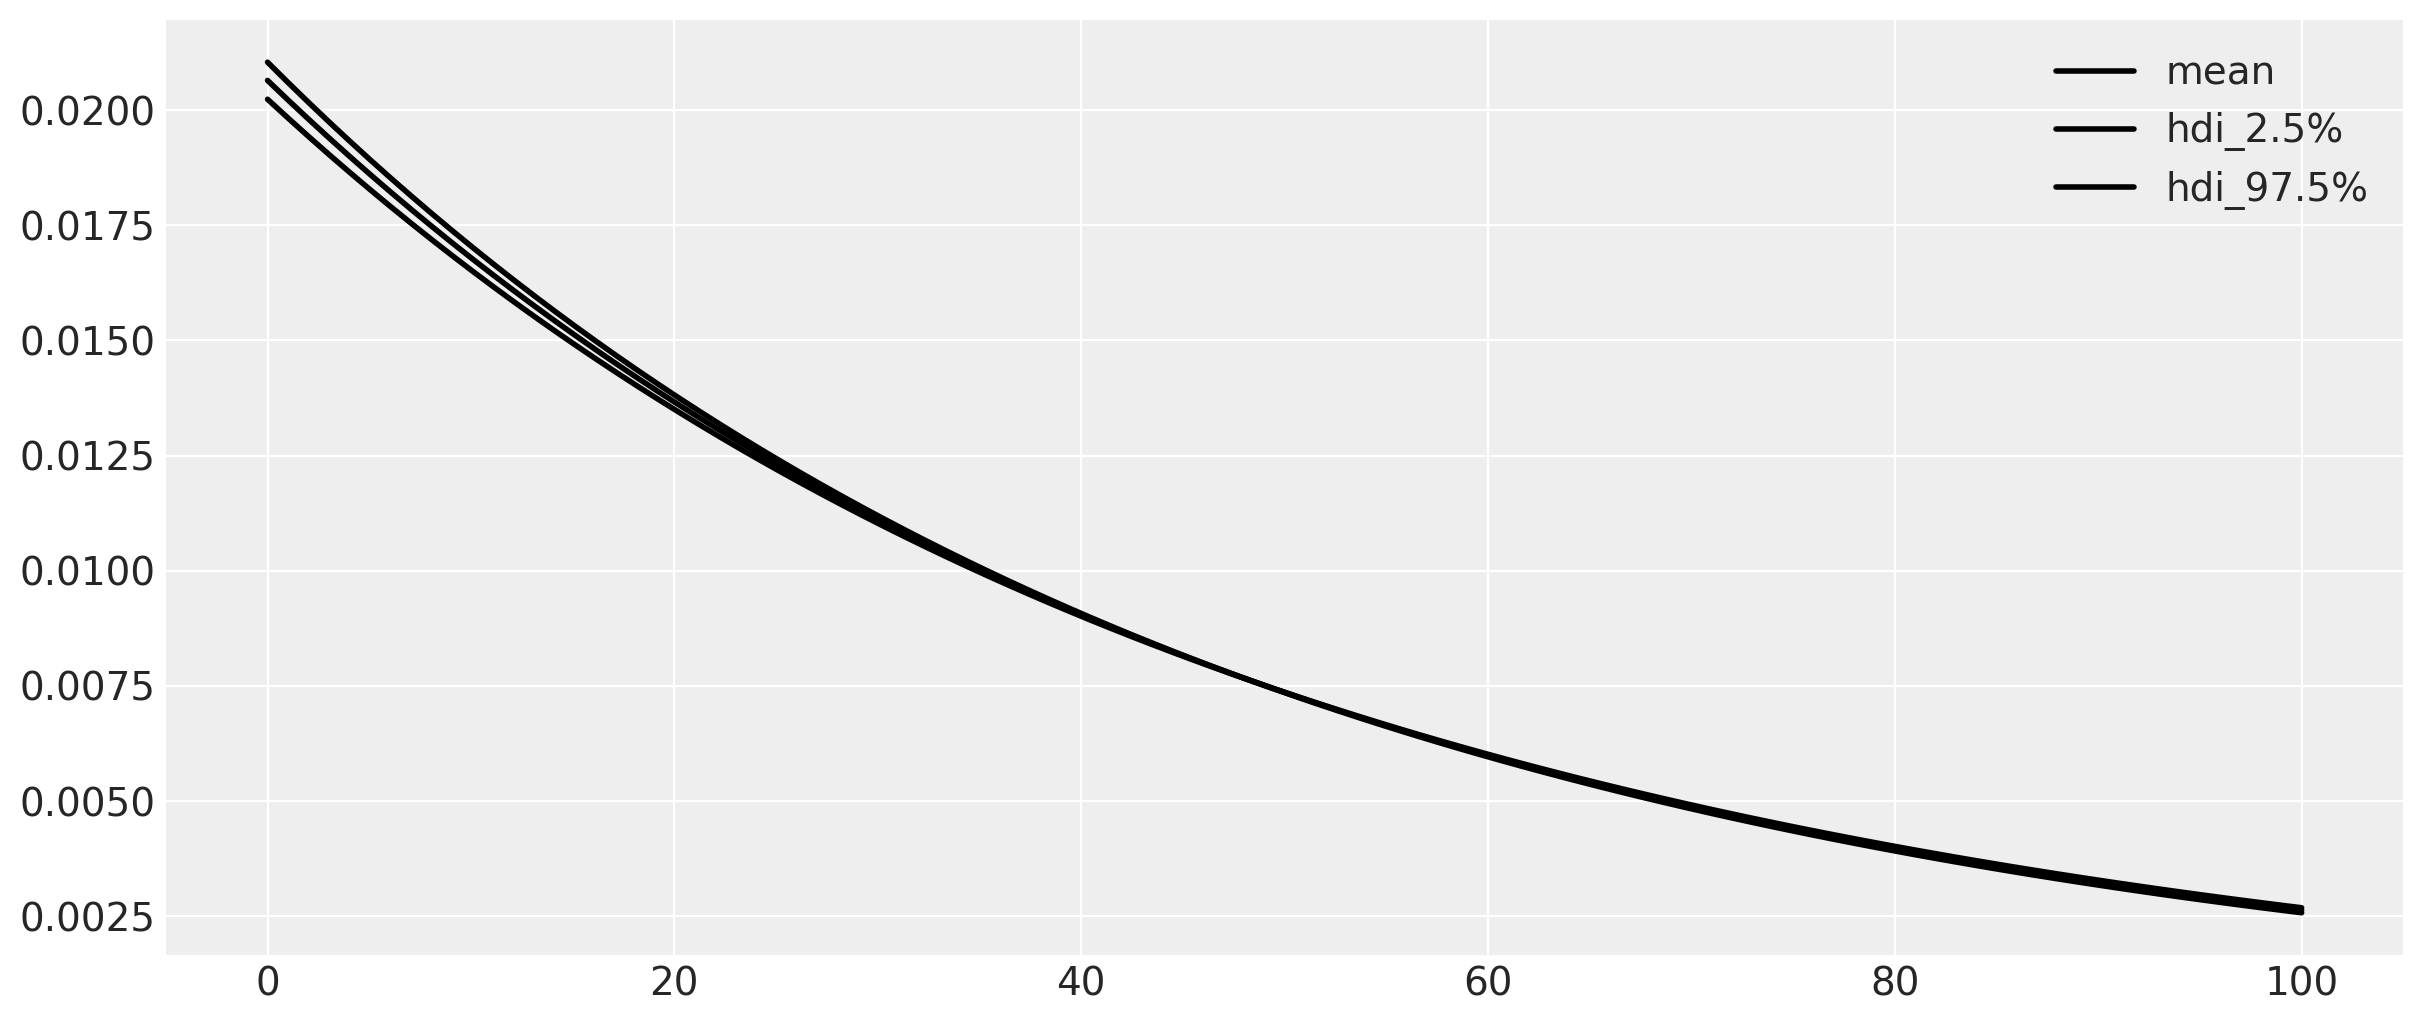

In [114]:
# per https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
# A common parameterization for expon is in terms of the rate parameter lambda, 
# such that pdf = lambda * exp(-lambda * x). 
# This parameterization corresponds to using scale = 1 / lambda.

f, ax = plt.subplots(figsize=(12,5))

for x in rate_other.index:
    rv = expon(scale=(1/rate_other[x]))  # has default loc=0, scale=1, size=1
    ax.plot(time, rv.pdf(time), 'k-', lw=2, label=x)

ax.legend()




In [96]:
rv1.pdf()

TypeError: rv_continuous_frozen.pdf() missing 1 required positional argument: 'x'

In [33]:
d.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,black,adopted,censored
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,other,0,1
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,other,0,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,other,1,0
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,other,0,1
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,other,0,1


# Create synthetic `cafe` dataset

The dataset I am using is created from a scenario described in Statistical Rethinking.

Here are a few more details of the dataset from Dr. McElreath's book:
> Begin by defining the population of cafés that the robot might visit. This means we’ll define the average wait time in the morning and the afternoon, as well as the correlation between them. These numbers are sufficient to define the average properties of the cafés. Let’s define these properties, then we’ll sample cafés from them.

Nearly all Python code is taken from the [Statistical Rethinking pymc repo](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) with some minor alterations.

In [5]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)  # covariance matrix

N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

Now simulate the observations.

In [151]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
df_cafes = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

To get a sense of the data structure we just created, let's take a look at the first and last 5 rows.

In [7]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,2.724888
1,0,1,1.951626
2,0,0,2.488389
3,0,1,1.188077
4,0,0,2.026425


In [8]:
df_cafes.tail()

,cafe,afternoon,wait
195,19,1,3.394933
196,19,0,4.544430
197,19,1,2.719524
198,19,0,3.379111
199,19,1,2.459750


Note that this dataset is balanced, meaning that each group (cafe) has the same number of observations. Mixed effects / multilevel models shine with unbalanced data where it can leverage partial pooling.

# Visualize data

Let's plot the raw data and see how the effect of afternoon influences wait time. Instead of plotting in order of the arbitrarily named cafes (0 to 19), I'll show in order of increasing average morning wait time so that we can appreciate the variability across the dataset.

In [212]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,2.644592
1,0,1,2.126485
2,0,0,2.596465
3,0,1,2.250297
4,0,0,3.310709


As you can see we get very similar intercepts and slopes for the cafe-specific estimates (varying effects) for the intercept and slope between the `lmer` and `pymc` approaches.

# Summary

Here in this post, I set out to compare different mixed model approaches. I looked at the equations and the programmatic implementations. I concluded by showing how the two methods can arrive at the same answer. It required a careful understanding of the differences in equations and coding language- and package-specific implementations. There were various points of writing this post that confused me but it provided opportunities for deeper understanding.

# Acknowledgements and references

Acknowledgements


References


In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Jul 01 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

arviz     : 0.15.1
numpy     : 1.25.0
pandas    : 2.0.3
matplotlib: 3.7.1
pymc      : 5.5.0
xarray    : 2023.6.0

Watermark: 2.4.2

